# 📌 Credit Card Fraud Detection - Model Evaluation & Fraud Analysis

Fraud detection models require rigorous evaluation to ensure they generalize well.  
This notebook focuses on **loading the trained model, evaluating performance, analyzing false positives & negatives, and extracting flagged fraud cases**.

---

## 🔹 Workflow Overview  

#### **1. Load the Trained Model**   
- Load the saved `.h5` model.
- Load preprocessed test datasets (`X_test`, `y_test`).

####  **2. Evaluate Model Performance**   
- Generate **loss curves** to assess model stability.  
- Analyze **precision, recall, and F1-score** for fraud detection.

####  **3. Generate Confusion Matrix**   
- Evaluate the **distribution of true vs. false positives/negatives**.  
- Identify areas of improvement.

#### **4. Extract and Analyze Fraudulent Transactions**   
- Extract transactions **flagged as fraud** by the model.
- Analyze transaction characteristics and compare them with non-fraudulent cases.


## **1. Load Required Libraries**  

we need to import essential libraries for data processing, visualization, and model evaluation.

- `numpy` and `pandas` for efficient data manipulation.
- `seaborn` and `matplotlib` for exploratory data analysis (EDA).
- `scikit-learn` for data preprocessing, model evaluation, and performance metrics.
- `tensorflow` and `keras` for deep learning implementation.



In [5]:
# Load Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K



## **2. Load the Trained Model**   

The trained **Neural Network model** is loaded from the `.h5` file saved in the previous notebook.  
Since we used **Focal Loss**, a custom loss function, we must explicitly pass it when loading the model.  

### ✅ **Key Fix**
- TensorFlow does not recognize custom loss functions by default.
- We redefine `focal_loss` and pass it under `custom_objects` while loading the model.

### ✅ **Steps Performed**
1. Load **preprocessed test data (`X_test`, `y_test`)**.
2. Load **saved trained model (`.h5`)** using `keras.models.load_model()`.
3. Register **Focal Loss** so the model is loaded correctly.
4. Print the **model summary** to verify the architecture.


In [3]:
# Define Custom Focal Loss Again (MUST be passed when loading the model)
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        epsilon = 1e-7
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        
        cross_entropy = -y_true * K.log(y_pred) - (1.0 - y_true) * K.log(1.0 - y_pred)
        weight = alpha * y_true * tf.pow((1.0 - y_pred), gamma) + \
                 (1.0 - alpha) * (1.0 - y_true) * tf.pow(y_pred, gamma)
        
        loss = weight * cross_entropy
        return tf.reduce_mean(loss)
    
    return focal_loss_fixed

# Define Paths
model_path = "/Users/adityaiyer/Desktop/Credit-Card-Fraud-Detection/models/fraud_model.h5"
data_path = "/Users/adityaiyer/Desktop/Credit-Card-Fraud-Detection/data/processed/"

# Load Preprocessed Test Data
X_test = np.load(data_path + "X_test.npy")
y_test = np.load(data_path + "y_test.npy")

# Load Trained Model with Custom Loss
model = keras.models.load_model(
    model_path,
    custom_objects={"focal_loss_fixed": focal_loss(gamma=2.0, alpha=0.25)}
)


model.summary()

print("✅ Model loaded successfully with Focal Loss!")


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 256)            │         7,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,947 (199.02 KB)

 Trainable params: 50,049 (195.50 KB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 2 (12.00 B)

✅ Model loaded successfully with Focal Loss!


## **3. Model Evaluation**  

After loading the trained model, we evaluate its performance on the **test set (`X_test`, `y_test`)**.  
Since fraud detection is an **imbalanced classification problem**, relying on accuracy alone is insufficient.  
Instead, we use multiple evaluation metrics to get a clearer picture of the model's effectiveness.

---

### ✅ **Metrics Used**  

1. **Accuracy**  
   - Measures overall correctness of the model.  
   - May be misleading in imbalanced datasets.

2. **Precision**  
   - How many predicted fraud cases were actually fraud?  
   - Higher precision reduces false positives.  

3. **Recall**  
   - How many actual fraud cases were correctly detected?  
   - Higher recall reduces false negatives.

4. **F1 Score**  
   - Balances **Precision** and **Recall**, making it a reliable metric for imbalanced data.

---

### 📊 **Confusion Matrix Visualization**  
We also **visualize the Confusion Matrix** to analyze:  
- **False Positives (FP)** → Normal transactions wrongly flagged as fraud.  
- **False Negatives (FN)** → Fraudulent transactions mistakenly classified as normal.  

A **well-performing model** should have:
✔ **High true positive (TP) rate** for fraud cases.  
✔ **Low false positive (FP) and false negative (FN) rates**.  

---


2671/2671 ━━━━━━━━━━━━━━━━━━━━ 1s 283us/step

=== Model Evaluation Metrics ===
🔹 Accuracy:  0.9990
🔹 Precision: 0.9275
🔹 Recall:    0.4324
🔹 F1 Score:  0.5899


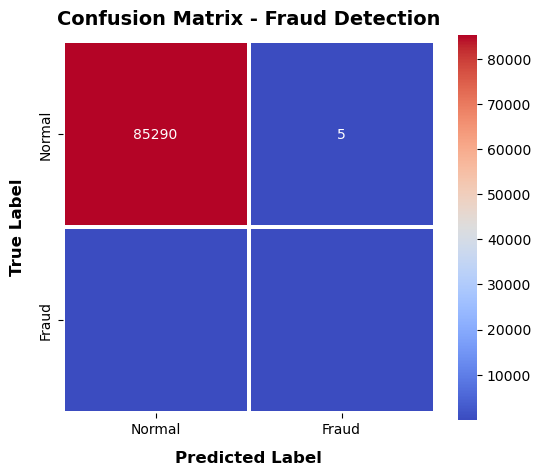

✅ Confusion Matrix saved successfully!


In [10]:

# Make Predictions
y_test_pred_probs = model.predict(X_test).ravel()

# Convert Probabilities to Binary Predictions
threshold = 0.5  # Standard threshold for classification
y_test_pred = (y_test_pred_probs >= threshold).astype(int)

# Compute Metrics
acc = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred)
rec = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

# Performance Metrics
print("\n=== Model Evaluation Metrics ===")
print(f"🔹 Accuracy:  {acc:.4f}")
print(f"🔹 Precision: {prec:.4f}")
print(f"🔹 Recall:    {rec:.4f}")
print(f"🔹 F1 Score:  {f1:.4f}")

# Compute Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

# Save Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', linewidths=1.5, square=True, 
            cbar=True, xticklabels=["Normal", "Fraud"], yticklabels=["Normal", "Fraud"])

plt.xlabel("Predicted Label", fontsize=12, fontweight='bold', labelpad=10)
plt.ylabel("True Label", fontsize=12, fontweight='bold', labelpad=10)
plt.title("Confusion Matrix - Fraud Detection", fontsize=14, fontweight='bold', pad=12)


plt.savefig("/Users/adityaiyer/Desktop/Credit-Card-Fraud-Detection/outputs/confusion_matrix.png", dpi=300, bbox_inches='tight')


plt.show()
print("✅ Confusion Matrix saved successfully!")


In [11]:
# Store Model Evaluation Metrics
metrics = {
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1 Score": f1
}


metrics_path = "/Users/adityaiyer/Desktop/Credit-Card-Fraud-Detection/outputs/evaluation_metrics.txt"
with open(metrics_path, "w") as f:
    for key, value in metrics.items():
        f.write(f"{key}: {value:.4f}\n")

print(f"✅ Model evaluation metrics saved at: {metrics_path}")


✅ Model evaluation metrics saved at: /Users/adityaiyer/Desktop/Credit-Card-Fraud-Detection/outputs/evaluation_metrics.txt


## **4. Extract & Analyze Fraudulent Transactions**
After evaluating the model, we extract **transactions flagged as fraud** to analyze their characteristics.

### ✅ **Steps:**
1. Convert `X_test` (if it's a NumPy array) into a **DataFrame**.
2. Extract **fraudulent transactions** using the model’s predictions.
3. Display a **sample of detected fraud cases** for manual inspection.
4. Save fraud cases to a CSV file for further analysis.

This helps in understanding what patterns the model considers fraudulent and refining the detection system.


In [16]:
import pandas as pd
import numpy as np

#Convert NumPy array to DataFrame (Ensure Column Names are Correct)
columns = [f'V{i}' for i in range(1, 29)] + ["Amount", "Time"]  
X_test_df = pd.DataFrame(X_test, columns=columns)

# Extract transactions flagged as fraud
fraud_indices = np.where(y_test_pred == 1)[0]  
fraud_cases = X_test_df.iloc[fraud_indices].copy()  

# Reset Index for Clean Output
fraud_cases.reset_index(drop=True, inplace=True)

# Display Sample Fraud Cases
print("\n🔍 Fraudulent Transactions Detected by the Model:\n")
print(fraud_cases.head())

# Save Fraudulent Transactions 
fraud_cases.to_csv("/Users/adityaiyer/Desktop/Credit-Card-Fraud-Detection/outputs/detected_fraud_cases.csv", index=False)
print("✅ Fraud cases saved to /Users/adityaiyer/Desktop/Credit-Card-Fraud-Detection/outputs/detected_fraud_cases.csv")



🔍 Fraudulent Transactions Detected by the Model:

         V1         V2        V3         V4        V5         V6        V7  \
0 -1.128572  -7.731412  4.496687 -10.772688  6.498647  -9.681829 -2.209807   
1  1.074242   0.463557  1.736440  -3.719073  4.247607   0.155738 -1.790334   
2  0.109825 -10.029916  8.962974 -15.017672  8.561871 -10.711361  0.628847   
3 -1.134173  -2.713928  2.526858  -5.619427  5.897613  -4.111121 -2.273396   
4 -1.087383  -1.718806  1.478931  -2.470834  0.196116  -1.657888 -1.464989   

          V8        V9       V10  ...       V21        V22       V23  \
0 -12.853497  8.385738 -7.200934  ... -2.202172   4.259077  0.468727   
1  -1.446658  0.283518 -2.569872  ...  0.318113   0.550153 -0.547934   
2 -22.272181 -9.916865 -8.166069  ...  5.001409 -11.139194  4.562954   
3  -8.737723  2.834497 -5.620241  ...  1.501860   3.154640  1.185810   
4  -2.408722 -1.391549  0.167467  ... -0.045262   2.800747 -0.706381   

        V24       V25       V26       V27      